In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

import os
import sys

sys.path.append('../../utils')
import lec6_graphs as afx

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Determinar Cantidad de cluster

#### Tipos de matrices de covarianza

* **Spherical**: Un valor de varianza por cluster (Formas esfericas, de diferentes tamaños)
* **Diag**: Matriz diagonal de covarianza (formas elipsoidales)
* **Tied**: Matriz de covarianza completa única para todos los clusters
* **Full**: Matriz de covarianza completa por cada cluster

![](cov_matrix.png)

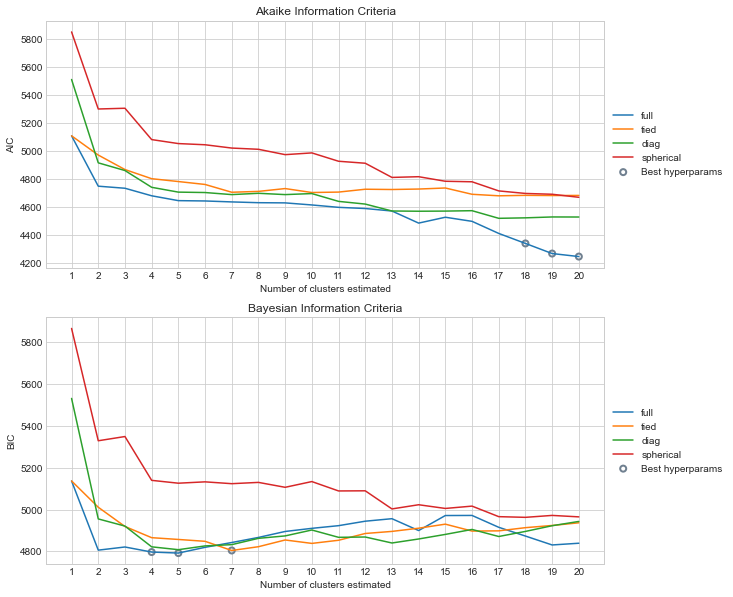

In [3]:
df = pd.read_csv('../../data/un3_diabetes.csv').drop(columns='Unnamed: 0')
plt.figure(figsize=(10, 10))
afx.gmm_information_criteria_report(df.loc[:,'glucose':'sspg'], k=np.arange(1, 21))

In [20]:
df.loc[:,'class'].value_counts()

Normal      76
Chemical    36
Overt       33
Name: class, dtype: int64

## Utilizamos el modelo GMM

In [32]:
x_mat = df.loc[:,'glucose':'sspg']
X = StandardScaler().fit_transform(x_mat)
df['y'] = LabelEncoder().fit_transform(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X,df['y'], random_state=11238,test_size=.33)

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=323).fit(X_train)
predict_classes_gmm = gmm.predict(X_test)

In [33]:
pd.crosstab(predict_classes_gmm, y_test)

y,0,1,2
row_0,,,
0,0,0,4
1,13,23,1
2,0,1,6


In [34]:
print(classification_report(y_test,predict_classes_gmm))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.62      0.96      0.75        24
           2       0.86      0.55      0.67        11

    accuracy                           0.60        48
   macro avg       0.49      0.50      0.47        48
weighted avg       0.51      0.60      0.53        48



## Como se compone cada cluster

In [26]:
for i,n in enumerate(df['class'].unique()):
    print("Ponderador para clase {}: {}".format(i,gmm.weights_[i]))
    for j, k in enumerate(x_mat.columns):
        print("Media {}: {}".format(k, gmm.means_[i][j]))
        #print("Covarianza {}: {}".format(k,gmm.covariances_[i][j]))
    print("\n", 50 * '=', "\n")

Ponderador para clase 0: 0.05133856305071589
Media glucose: 3.2608798453954106
Media insulin: 2.911278526535579
Media sspg: -1.324126054243474


Ponderador para clase 1: 0.7437917772761508
Media glucose: -0.44724087441501065
Media insulin: -0.48922994670086056
Media sspg: 0.25190212756632374


Ponderador para clase 2: 0.20486965967313353
Media glucose: 0.6670500303419262
Media insulin: 0.8945875189421094
Media sspg: -0.5891501286942962




In [27]:
print("Densidades de cada clase inferida: ", gmm.weights_.round(3))
print("Suma de densidades: ", np.sum(gmm.weights_).round(3))

Densidades de cada clase inferida:  [0.051 0.744 0.205]
Suma de densidades:  1.0


In [8]:
gmm.predict_proba(X).round(3)[60:70]

array([[0.   , 0.982, 0.018],
       [0.   , 0.953, 0.047],
       [0.   , 0.993, 0.007],
       [0.   , 0.992, 0.008],
       [0.   , 0.78 , 0.22 ],
       [0.   , 0.951, 0.049],
       [0.   , 0.987, 0.013],
       [0.   , 0.995, 0.005],
       [0.   , 1.   , 0.   ],
       [0.   , 0.906, 0.094]])

## Probamos con diferentes matrices de covarianza

In [9]:
# Definimos la matriz de atributos
X = df.loc[:,['glucose', 'insulin']]
# definimos todas las opciones
covar_candidate = ['full', 'tied', 'spherical', 'diag']

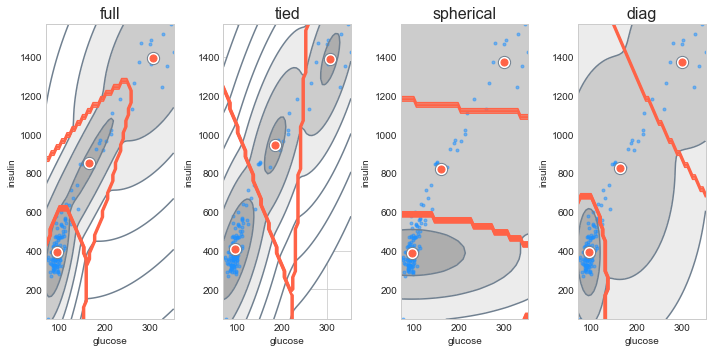

In [10]:
plt.figure(figsize=(10, 5))
for index, varname in enumerate(covar_candidate):
    plt.subplot(1, 4, index + 1)
    afx.plot_gaussian_ellipses(GaussianMixture(n_components=3, covariance_type=varname, random_state=323).fit(X),X=X)
    plt.tight_layout(); 
    plt.title(varname, fontsize=16)

In [13]:
for covar in ['full', 'tied', 'spherical', 'diag']:
    tmp_gmm = GaussianMixture(n_components=3, covariance_type=covar, random_state=323).fit(X_train)
    print(covar, "\n", classification_report(y_test, tmp_gmm.predict(X_test)))

full 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.62      0.96      0.75        24
           2       0.86      0.55      0.67        11

    accuracy                           0.60        48
   macro avg       0.49      0.50      0.47        48
weighted avg       0.51      0.60      0.53        48

tied 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.74        24
           2       1.00      0.27      0.43        11

    accuracy                           0.56        48
   macro avg       0.53      0.42      0.39        48
weighted avg       0.52      0.56      0.47        48

spherical 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.59      1.00      0.74        24
           2       1.00      0.18      0.31      